In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
path = 'data.csv'
data = pd.read_csv(path)

In [4]:
data

,y,Vgs,psi
0,0.000000e+00,-2.0,-3.338811e-01
1,1.002004e-09,-2.0,-2.068096e-01
2,2.004008e-09,-2.0,-1.731366e-01
3,3.006012e-09,-2.0,-1.529357e-01
4,4.008016e-09,-2.0,-1.384912e-01
...,...,...,...
49995,4.959920e-07,2.0,5.169869e-05
49996,4.969940e-07,2.0,3.874753e-05
49997,4.979960e-07,2.0,2.581908e-05
49998,4.989980e-07,2.0,1.290576e-05


In [5]:
X = np.array(data.iloc[:, :2])
y = np.array(data.iloc[:, 2])
y = y.reshape(y.shape[0], 1)

In [6]:
X

array([[ 0.00000000e+00, -2.00000000e+00],
       [ 1.00200401e-09, -2.00000000e+00],
       [ 2.00400802e-09, -2.00000000e+00],
       ...,
       [ 4.97995992e-07,  2.00000000e+00],
       [ 4.98997996e-07,  2.00000000e+00],
       [ 5.00000000e-07,  2.00000000e+00]])

In [7]:
y.shape

(50000, 1)

In [8]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5)

In [10]:
lam = tf.keras.regularizers.l2(l=0)
init = tf.initializers.he_normal()
model = tf.keras.Sequential([
    tf.keras.layers.Dense(40, input_dim=2, kernel_initializer=init, kernel_regularizer=lam),
    tf.keras.layers.Activation('tanh'),
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(40, kernel_initializer=init, kernel_regularizer=lam),
    tf.keras.layers.Activation('tanh'),
    # tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Dense(40, kernel_initializer=init, kernel_regularizer=lam),
    tf.keras.layers.Activation('tanh'),
    # tf.keras.layers.Dropout(0.2),

    # tf.keras.layers.Dense(40, kernel_initializer=init, kernel_regularizer=lam),
    # tf.keras.layers.Activation('tanh'),

    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 40)                120       
_________________________________________________________________
activation (Activation)      (None, 40)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                1640      
_________________________________________________________________
activation_1 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 40)                1640      
_________________________________________________________________
activation_2 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 4

In [11]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.001)
# early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
model.compile(loss='mse', optimizer=opt)

In [12]:
history = model.fit(X_train, y_train, epochs=500, batch_size=128, validation_split=0.2, shuffle=True, callbacks=[reduce_lr])

Epoch 1/500
157/157 [==============================] - 5s 11ms/step - loss: 0.1362 - val_loss: 0.0039
Epoch 2/500
157/157 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0021
Epoch 3/500
157/157 [==============================] - 1s 4ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 4/500
157/157 [==============================] - 0s 3ms/step - loss: 0.0012 - val_loss: 9.8290e-04
Epoch 5/500
157/157 [==============================] - 0s 3ms/step - loss: 8.5663e-04 - val_loss: 7.9982e-04
Epoch 6/500
157/157 [==============================] - 0s 3ms/step - loss: 6.5223e-04 - val_loss: 6.3463e-04
Epoch 7/500
157/157 [==============================] - 0s 3ms/step - loss: 5.6043e-04 - val_loss: 5.3653e-04
Epoch 8/500
157/157 [==============================] - 0s 2ms/step - loss: 4.5884e-04 - val_loss: 4.5135e-04
Epoch 9/500
157/157 [==============================] - 0s 3ms/step - loss: 4.2145e-04 - val_loss: 4.0469e-04
Epoch 10/500
157/157 [========================

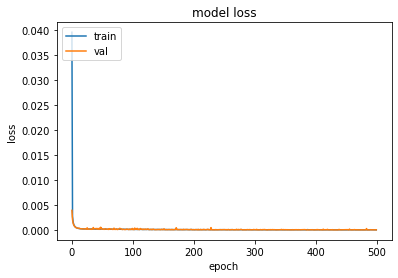

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
y_pred = model.predict(X_test)

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [16]:
mean_squared_error(y_test, y_pred), mean_absolute_error(y_test, y_pred)

(2.0737228792386002e-05, 0.0025790573681865694)

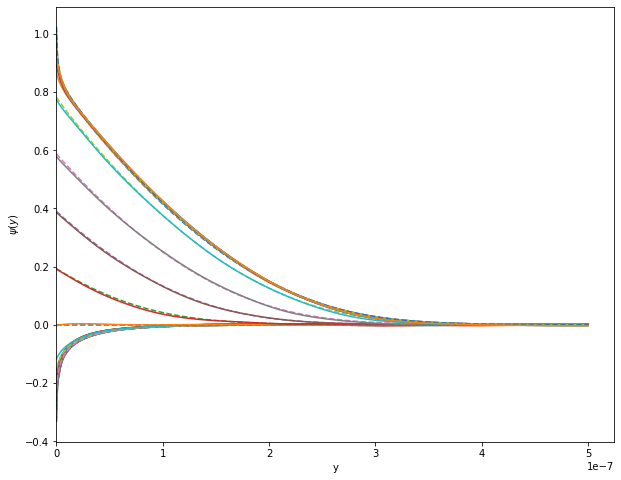

In [22]:
import math
from scipy.integrate import solve_bvp

N_A = 1e22
t_ox = 1e-9
t_si = 5e-7
epsilon_0 = 8.85418781e-12
epsilon_si = epsilon_0*11.9
epsilon_sio2 = epsilon_0*3.9
delta_psi_MS = 0.21
psi_t = 26e-3
n_i = 1e16
psi_F = psi_t*math.log(N_A/n_i)
q = 1.6e-19

def fun(y, psi):
    A = q*N_A/epsilon_si
    first = psi[1]
    second = -A*(np.exp(-psi[0]/psi_t) - 1 - np.exp(-2*psi_F/psi_t)*(np.exp(psi[0]/psi_t) - 1))
    return np.array([first, second])

def bc(psi_a, psi_b):
    Cox = epsilon_sio2/t_ox
    B = Cox/epsilon_si
    first = +psi_a[1] + B*(Vg - psi_a[0])
    second = psi_b[0]
    return np.array([first, second])

yy = np.linspace(0, 5e-7, 500)
psii = np.zeros((2, yy.size))

plt.figure(figsize=(10, 8))
Vgs = np.linspace(-2, 2, 21)
psi_out = []
for i in Vgs:
    Vg = i
    sol = solve_bvp(fun, bc, yy, psii, tol=1e-3, max_nodes=20000)
    plt.plot(yy, sol.sol(yy)[0], label='Vgs=' + str(i)[:4], linestyle='dashed')

    vgs = np.ones_like(yy)*i
    inp = np.vstack([yy, vgs])
    inp = np.transpose(inp)
    inp = scaler.transform(inp)
    psi = model.predict(inp)
    plt.plot(yy, psi)

    psi_out.append(list(sol.sol(yy)[0]))
    
plt.xlabel("y")
plt.ylabel("$\psi(y)$")
plt.xlim(0)
plt.show()

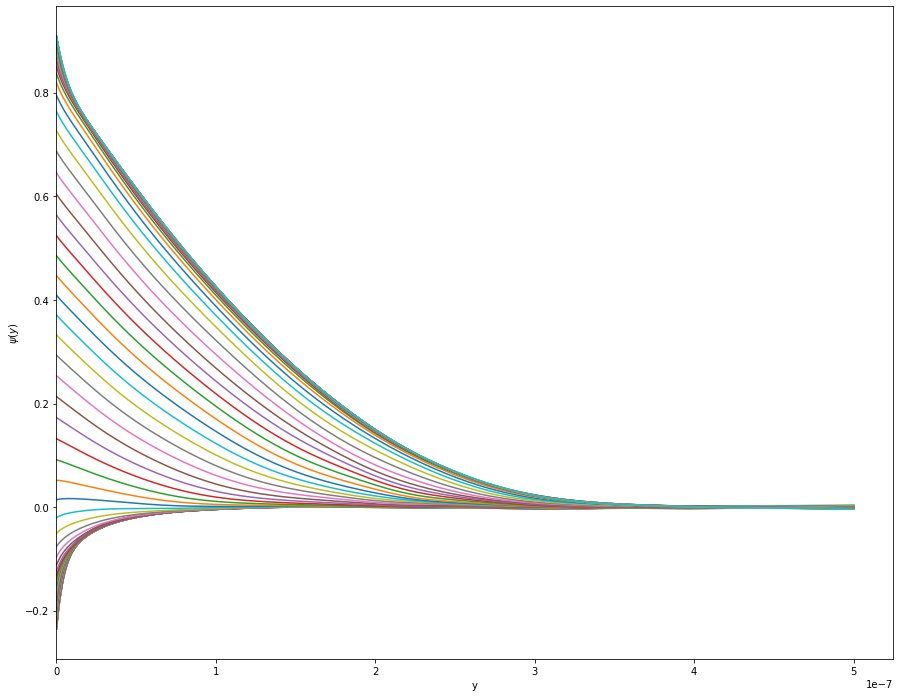

In [20]:
yy = np.linspace(0, 5e-7, 500)
Vgs = np.linspace(-2, 2, 100)
plt.figure(figsize=(15, 12))
for i in Vgs:
    vgs = np.ones_like(yy)*i
    inp = np.vstack([yy, vgs])
    inp = np.transpose(inp)
    inp = scaler.transform(inp)
    psi = model.predict(inp)
    # print(psi)
    # break
    plt.plot(yy, psi)
plt.xlabel("y")
plt.ylabel("$\psi(y)$")
plt.xlim(0)
plt.show()

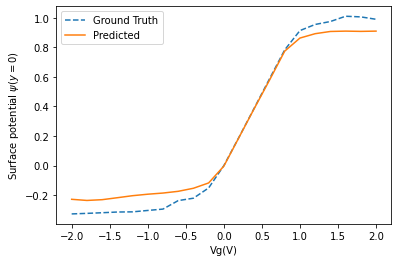

In [24]:
psii = np.zeros((2, yy.size))
Vgs = np.linspace(-2, 2, 21)
psi_zero = []
psi_zero_pred = []
for i in Vgs:
    Vg = i
    sol = solve_bvp(fun, bc, yy, psii, tol=1e-5, bc_tol=1e-5)
    psi_zero.append(sol.sol(yy)[0][0])

    zeros = np.zeros_like(yy)
    vgs = np.ones_like(yy)*i
    inp = np.vstack([zeros, vgs])
    inp = np.transpose(inp)
    inp = scaler.transform(inp)
    psi = model.predict(inp)
    psi_zero_pred.append(psi[0])

    
plt.plot(Vgs, psi_zero, linestyle='dashed')
plt.plot(Vgs, psi_zero_pred)
plt.xlabel("Vg(V)")
plt.ylabel("Surface potential $\psi(y=0)$")
plt.legend(['Ground Truth', 'Predicted'])
plt.show()
